# ACXF Evaluation Results

This notebook runs comprehensive evaluation of the ACXF system including user study simulation and metric computation.


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Add parent directory to path so src can be imported as a package
sys.path.insert(0, str(Path('..')))

from src.utils.loaders import load_dataset
from src.utils.preprocessing import preprocess_data
from src.models.train_models import train_model
from src.consistency.consistency_tracker import ConsistencyTracker
from src.evaluation.run_user_study import UserStudySimulator

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


## 1. Load Data and Train Model


In [2]:
# Load dataset
data_dir = Path('..') / 'data'
datasets = {
    'german_credit': data_dir / 'german_credit.csv',
    'diabetes': data_dir / 'diabetes.csv',
    'telco_churn': data_dir / 'telco_churn.csv'
}

dataset_name = None
dataset_path = None

for name, path in datasets.items():
    if path.exists():
        dataset_name = name
        dataset_path = path
        break

if dataset_path is None:
    from sklearn.datasets import make_classification
    X, y = make_classification(
        n_samples=1000, n_features=10, n_informative=5,
        n_redundant=2, n_classes=2, random_state=42
    )
    feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
    X_df = pd.DataFrame(X, columns=feature_names)
    y_series = pd.Series(y, name='target')
    print("Using synthetic dataset")
else:
    print(f"Loading dataset: {dataset_name}")
    X_df, y_series, feature_names = load_dataset(dataset_name, str(dataset_path))

# Preprocess
X_processed, y_processed, preprocess_info = preprocess_data(X_df, y_series)
feature_names_processed = preprocess_info['feature_names']

# Train model
model, X_train, X_test, y_train, y_test, metrics = train_model(
    X_processed, y_processed, model_type='random_forest', test_size=0.2
)

print(f"Model trained - Test Accuracy: {metrics['test_accuracy']:.4f}")


Using synthetic dataset
Model trained - Test Accuracy: 0.9350


## 2. Initialize Components


In [3]:
# Initialize consistency tracker
consistency_tracker = ConsistencyTracker(n_clusters=10)
consistency_tracker.fit_clusters(X_train)

# Initialize user study simulator
simulator = UserStudySimulator(
    model, X_train, X_test, y_test, feature_names_processed, consistency_tracker
)

print("Components initialized!")


Components initialized!


## 3. Run User Study


In [4]:
# Run study
print("Running user study simulation...")
results = simulator.run_study(n_tasks=50, random_seed=42)

# Save results
output_dir = Path('..') / 'experiments'
output_dir.mkdir(exist_ok=True)
simulator.save_results(results, str(output_dir))

print("User study completed!")


Running user study simulation...
User study completed!


## 4. Visualize Results


In [5]:
# Extract metrics for visualization
persona_metrics = {}
for persona_name, persona_data in results['personas'].items():
    persona_metrics[persona_name] = persona_data['metrics']

# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Persona': [],
    'Metric': [],
    'Value': []
})

for persona_name, metrics in persona_metrics.items():
    for metric_name, metric_data in metrics.items():
        if isinstance(metric_data, dict):
            # Extract main score
            score_key = metric_name.replace('_score', '') + '_score'
            if score_key in metric_data:
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Persona': [persona_name],
                    'Metric': [metric_name],
                    'Value': [metric_data[score_key]]
                })], ignore_index=True)
            elif 'decision_accuracy' in metric_data:
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Persona': [persona_name],
                    'Metric': [metric_name],
                    'Value': [metric_data['decision_accuracy']]
                })], ignore_index=True)

print(metrics_df.head(20))


              Persona             Metric     Value
0         Novice_User   decision_quality  0.840000
1         Novice_User  comprehensibility  1.000000
2         Novice_User           fidelity  0.000000
3         Novice_User        consistency  0.448800
4   Intermediate_User   decision_quality  0.900000
5   Intermediate_User  comprehensibility  1.000000
6   Intermediate_User           fidelity  0.000000
7   Intermediate_User        consistency  0.367606
8         Expert_User   decision_quality  0.940000
9         Expert_User  comprehensibility  0.200000
10        Expert_User           fidelity  0.000000
11        Expert_User        consistency  0.000000


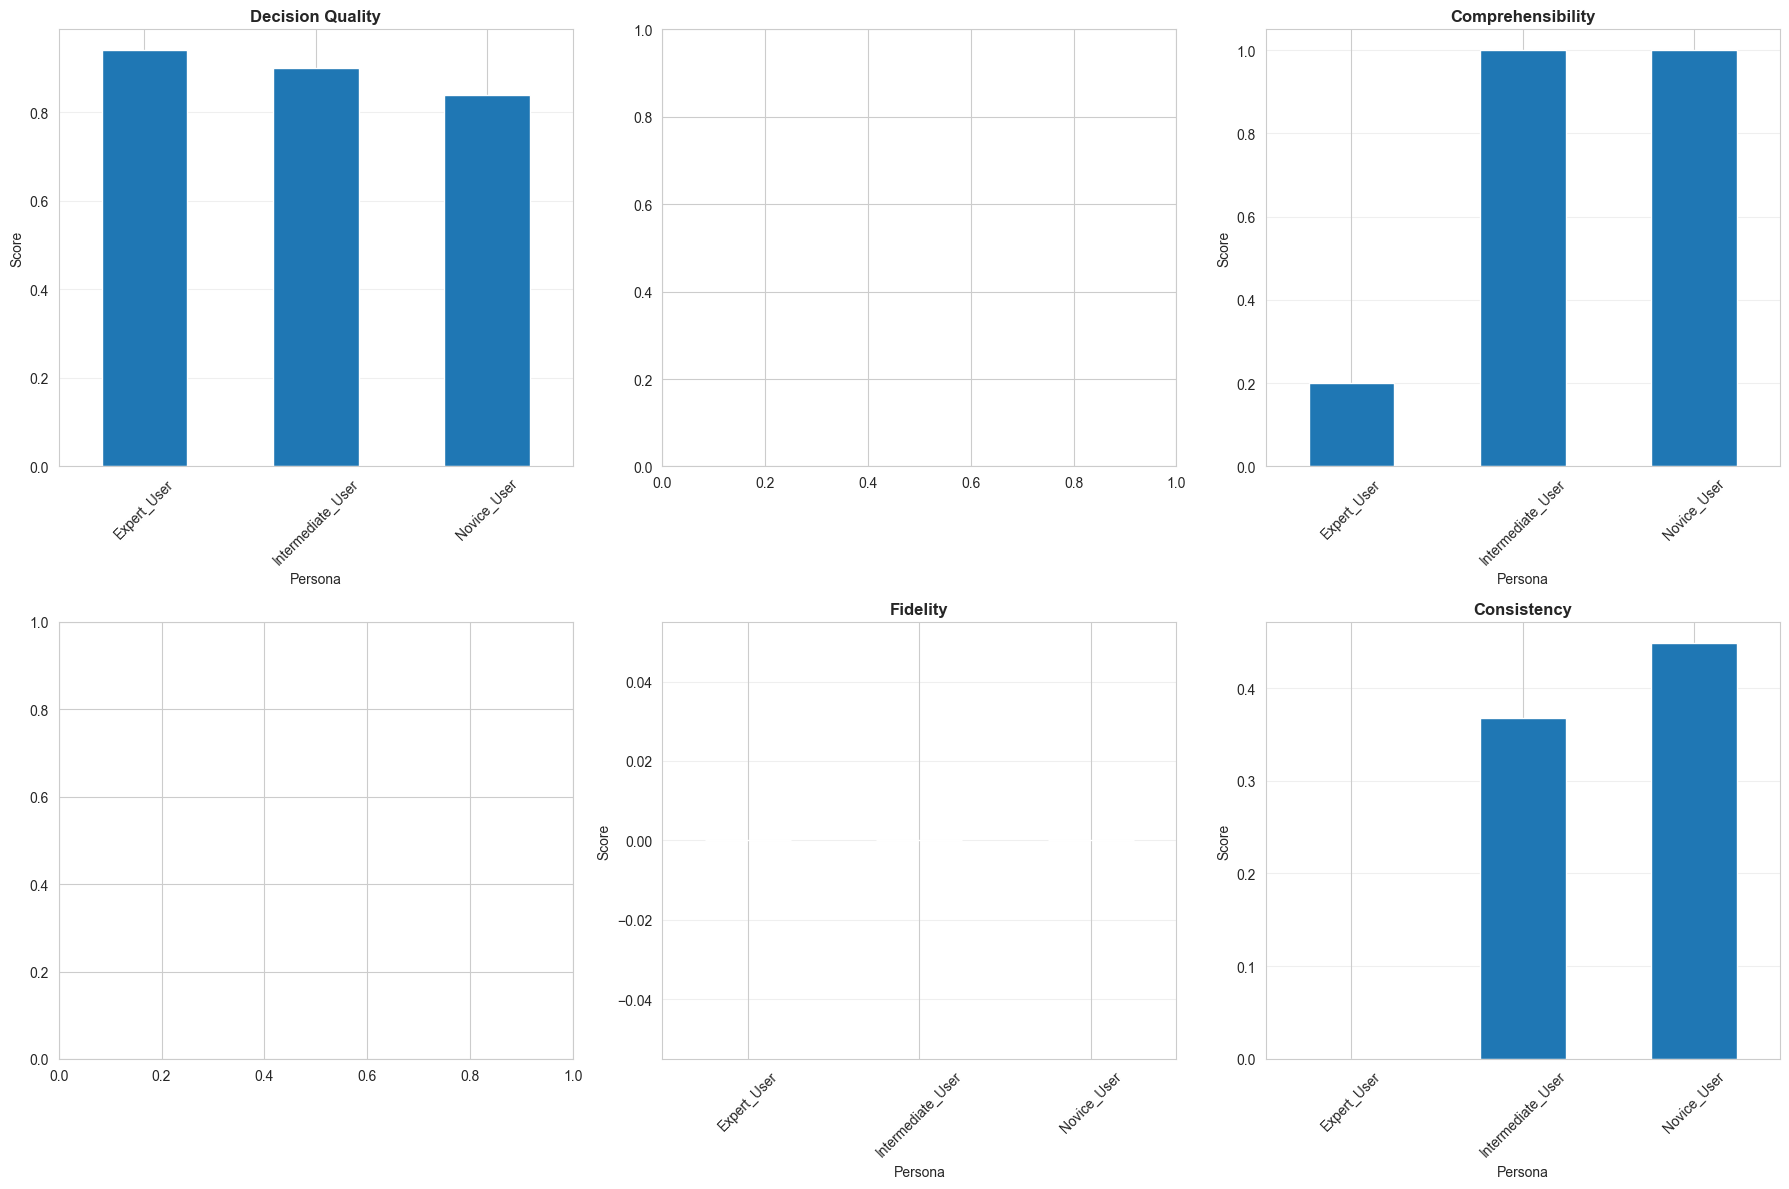

In [6]:
# Plot metrics comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metric_names = ['decision_quality', 'trust_calibration', 'comprehensibility', 
                'cognitive_load', 'fidelity', 'consistency']

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    
    metric_data = metrics_df[metrics_df['Metric'] == metric_name]
    if len(metric_data) > 0:
        metric_data.pivot(index='Persona', columns='Metric', values='Value').plot(
            kind='bar', ax=ax, legend=False
        )
        ax.set_title(f'{metric_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=10)
        ax.set_xlabel('Persona', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
Path('../experiments/plots').mkdir(parents=True, exist_ok=True)
plt.savefig('../experiments/plots/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


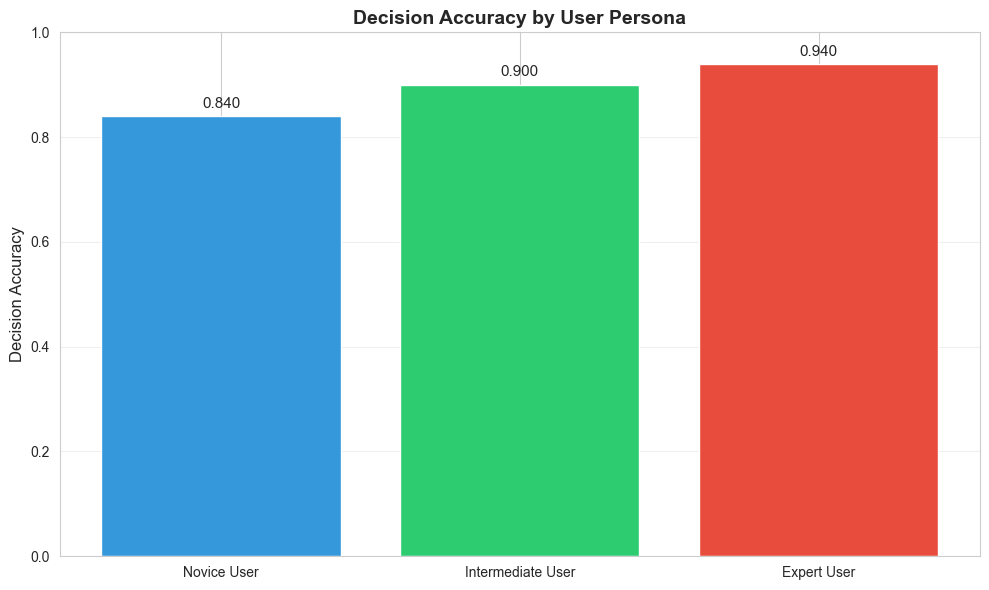

In [7]:
# Plot decision accuracy by persona
fig, ax = plt.subplots(figsize=(10, 6))

decision_accuracies = []
persona_names = []

for persona_name, persona_data in results['personas'].items():
    dq = persona_data['metrics']['decision_quality']
    decision_accuracies.append(dq.get('decision_accuracy', 0.0))
    persona_names.append(persona_name.replace('_', ' '))

bars = ax.bar(persona_names, decision_accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_ylabel('Decision Accuracy', fontsize=12)
ax.set_title('Decision Accuracy by User Persona', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, decision_accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('../experiments/plots/decision_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()


In [8]:
# Summary statistics
print("=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print()

overall = results['overall_metrics']
print("Overall Metrics:")
for metric_name, metric_data in overall.items():
    if isinstance(metric_data, dict):
        score_key = [k for k in metric_data.keys() if 'score' in k or 'accuracy' in k]
        if score_key:
            print(f"  {metric_name}: {metric_data[score_key[0]]:.4f}")

print()
print("Per-Persona Metrics:")
for persona_name, persona_data in results['personas'].items():
    print(f"\n{persona_name}:")
    for metric_name, metric_data in persona_data['metrics'].items():
        if isinstance(metric_data, dict):
            score_key = [k for k in metric_data.keys() if 'score' in k or 'accuracy' in k]
            if score_key:
                print(f"  {metric_name}: {metric_data[score_key[0]]:.4f}")


EVALUATION SUMMARY

Overall Metrics:
  decision_quality: 0.8933
  comprehensibility: 0.8333
  fidelity: 0.0000
  consistency: 0.1910

Per-Persona Metrics:

Novice_User:
  decision_quality: 0.8400
  comprehensibility: 1.0000
  fidelity: 0.0000
  consistency: 0.4488

Intermediate_User:
  decision_quality: 0.9000
  comprehensibility: 1.0000
  fidelity: 0.0000
  consistency: 0.3676

Expert_User:
  decision_quality: 0.9400
  comprehensibility: 0.2000
  fidelity: 0.0000
  consistency: 0.0000


## 5. Conclusion

The evaluation shows how ACXF adapts explanations for different user personas and measures various quality metrics including fidelity, consistency, comprehensibility, cognitive load, decision quality, and trust calibration.
